```
conda activate
cd ~/link/res_publish/plot

jupyter nbconvert EnrichmentAnalysis.ipynb --to python
mv EnrichmentAnalysis.py EnrichmentAnalysis.r

echo 'finish'
```

In [1]:
args=commandArgs(TRUE)
geneset_dir = 'data/EnrichmentAnalysis/geneset'

if('-h' %in% args | '--help' %in% args){
    cat(
'
---------------usage---------------
Rscript EnrichmentAnalysis.r res_dir geneset_label gene_string [separator]

---------------help---------------
Rscript EnrichmentAnalysis.r -h
Rscript EnrichmentAnalysis.r --help
')
    stop('[get help and exit]')
}else{
    cat(sprintf("%s\n",R.version.string))
}

R version 4.3.3 (2024-02-29)


In [2]:
library(tidyverse)
library(clusterProfiler)


args=commandArgs(TRUE)

# res_dir,gene_string,separator,file_path

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


clusterProfiler v4.10.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:purrr’:

    simplif

# parameter

In [3]:
res_dir = args[1]
geneset_label = args[2]
gene_string = args[3]
separator = args[4]
separator = ifelse(is.na(separator),',',separator)

# gene_string = 'Wisp2,Lox,Nt5dc2,Emb,Hp,Slc39a14,Chl1,Pcsk5,Mmp3,Wisp1,Zbp1,Slpi,Saa3,H2-Q7,Cxcl5,Irf7,Tnfsf11,Plac8,Ifi44,Gbp3,Mmp13,Chchd10,Olfr810,Inhbb,H2-Q6,Barx2,Lrg1,Chil1,Oas1a,Gas2,Kcnj15,Glipr1,Il13ra2,Masp1,Megf6,Saa2,Ly6h,Htr2a,Kcne4,Col23a1,Saa1,Kng2,Batf3,Cxcl9,Col24a1,Oas2,Slc16a4,Gm6093,Agtr2,Acpp,Cdk1,Ube2ql1,Trdc,Gm2115,Podnl1,Oas1g,Cdca3,Il1rn,Cela1,Ccnb2,Syt12,Tnfsf15,Ccl5,Lrrc34,A630023A22Rik,Apln,Adra2a,Myo16,Gnal,Wfdc21,Prss35,Rnf128,BC065403,Gm13293,D830036C21Rik,Serpina3g,Gm28054,Calml3,Epgn,Mmp12,Gm14002'
# geneset_label = 'm2.cp'
# res_dir = 'data/EnrichmentAnalysis/RA_m'

if(dir.exists(res_dir)){
    cat(sprintf('[exists] %s\n',res_dir))
}else{
    dir.create(res_dir,recursive = TRUE)
}

# gene set

In [4]:
gs_info = read.csv(file.path(geneset_dir,'geneset_info.csv')) %>%
    mutate(path = file.path(geneset_dir,path))

if(! geneset_label %in% gs_info$label){
    stop(sprintf('%s not in %s',geneset_label,paste(gs_info$label,collapse = ',')))
}
p_gs = filter(gs_info,label == geneset_label)$path %>% nth(1)
print(p_gs)
gs = read.csv(p_gs)
# gs %>% head(2)
cat(sprintf('[gene set] %d item\n',gs %>% distinct(gs_name) %>% nrow))

[1] "data/EnrichmentAnalysis/geneset/df_genesets_m2.cp.v2023.2.Mm.symbols.csv"
[gene set] 1701 item


# gene

In [5]:
gene = str_split(gene_string,separator)[[1]]
cat(sprintf('[gene length] %d\n',length(gene)))
cat(sprintf('[gene 5th] %s \n',paste(gene[1:5],collapse = ',')))
jsonlite::toJSON(list(geneset_label=geneset_label,
                      path_geneset=p_gs,gene=gene),
                 null = NULL,pretty = TRUE) %>%
    write(file.path(res_dir,'parameter.json'))
cat(sprintf('[out] %s\n',file.path(res_dir,'parameter.json')))

[gene length] 81
[gene 5th] Wisp2,Lox,Nt5dc2,Emb,Hp 
[out] data/EnrichmentAnalysis/RA_m/parameter.json


# Enrichment

In [6]:
res_enr <- enricher(gene, pvalueCutoff = 1, pAdjustMethod = "BH",
  TERM2GENE = gs %>% select(gs_name, gs_gene) %>% rename(gs_id = gs_name),
  TERM2NAME = gs %>% select(gs_name) %>% mutate(gs_id = gs_name) %>% distinct())

In [7]:
saveRDS(res_enr,file.path(res_dir,'Enrich.rds'))
cat(sprintf('[out] %s\n',file.path(res_dir,'Enrich.rds')))

[out] data/EnrichmentAnalysis/RA_m/Enrich.rds


In [8]:
df_enr = res_enr %>% as.data.frame
df_enr %>% write_csv(file.path(res_dir,'Enrich_table_all.csv'))
cat(sprintf('[Enrich item] %d total\n',df_enr %>% nrow))
df_enr = df_enr %>% filter(p.adjust < 0.05)
cat(sprintf('[Enrich item] %d p.adjust < 0.05\n',df_enr %>% nrow))
df_enr %>% write_csv(file.path(res_dir,'Enrich_table.csv'))
cat(sprintf('[out] %s\n',file.path(res_dir,'Enrich_table.csv')))

[Enrich item] 82 total
[Enrich item] 10 p.adjust < 0.05
[out] data/EnrichmentAnalysis/RA_m/Enrich_table.csv


[out] data/EnrichmentAnalysis/RA_m/Enrich_dotplot_25.png


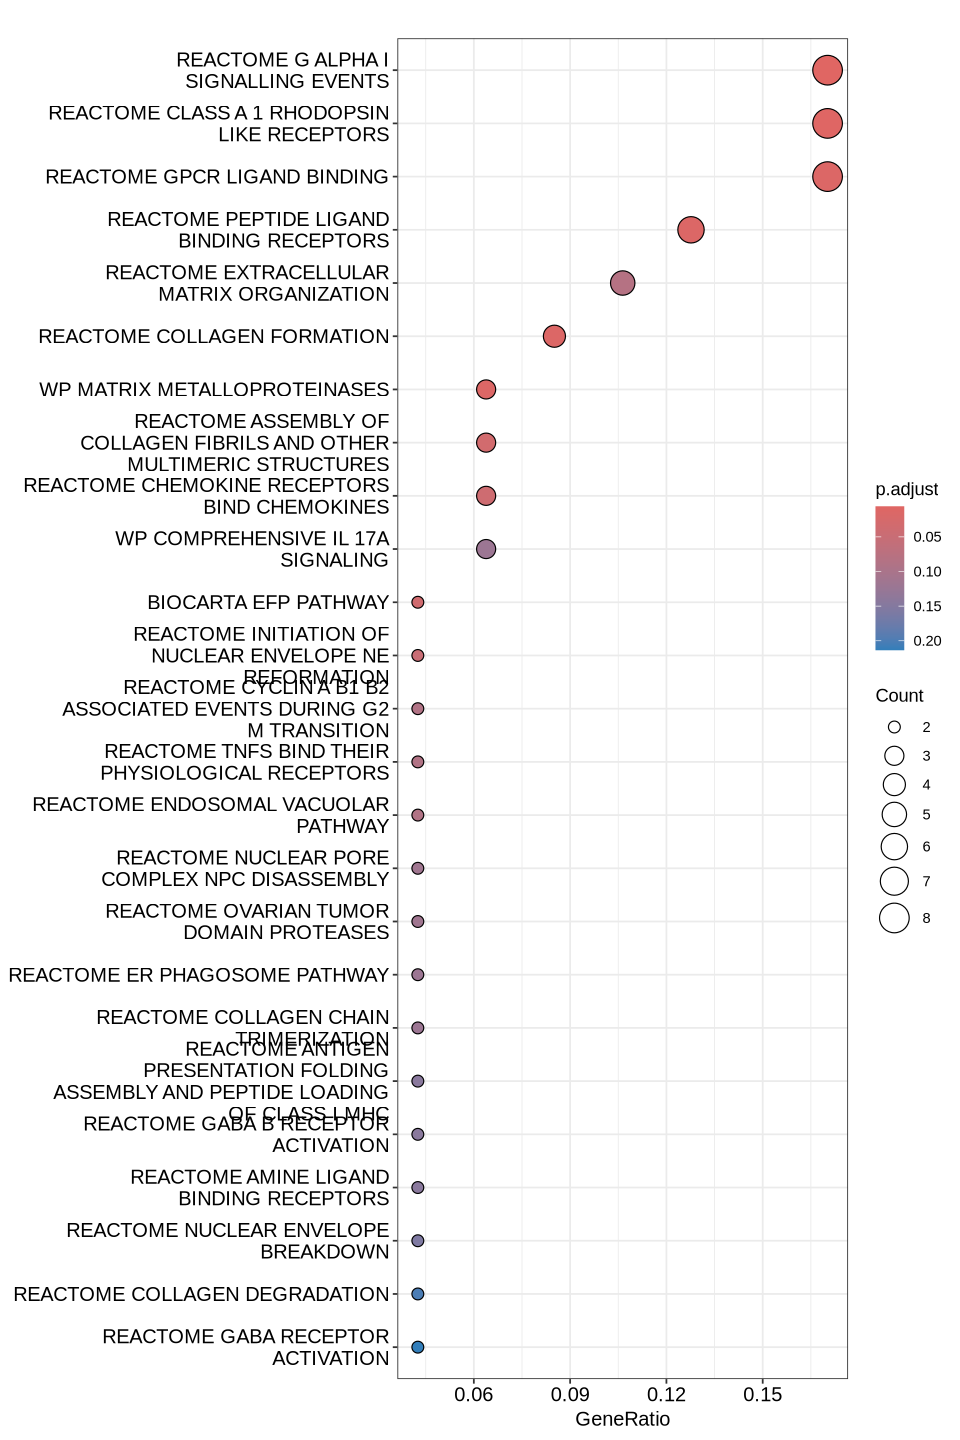

In [9]:
options(repr.plot.height = 12, repr.plot.width = 8)
p = res_enr %>% dotplot(x = "GeneRatio", color = "p.adjust", size = "Count",
        showCategory =25)
p
ggsave(file.path(res_dir,'Enrich_dotplot_25.png'),width = 8,height = 12,units = 'in')
cat(sprintf('[out] %s\n',file.path(res_dir,'Enrich_dotplot_25.png')))

In [10]:
cat(
'----------------------------------------
finish
----------------------------------------
')

----------------------------------------
finish
----------------------------------------
